<center>

# Generalized nonlinear Shr<span>&#246;</span>dinger equation

## Rishat Zagidullin, Skoltech Moscow


<font size=4>Email: <r.zagidullin@skoltech.ru> </font>

$
    \dfrac{\partial A}{\partial z} = -i\dfrac{\beta_2}{2}\dfrac{\partial^2 A}{\partial t^2} + \dfrac{\beta_3}{6}\dfrac{\partial^3 A}{\partial t^3} + i\gamma |A|^2 + \hat{g} A- \alpha A
$,  
$A(t,z)$ - signal  
$z$ - signal displacement in a lengh of fiber  
$t$ - time  
$\alpha$ - fiber losses  
$\hat{g}$ - gains, gets recomputed at every timestep
$\gamma$ - non-linear parameter  
$\beta_2$ - 2nd order dispersion  
$\beta_3$ - 3rd odrer dispersion  
$i$ - imaginary unit

### pycuda FFT version

In [143]:
from scipy.fftpack import fft, ifft
import pandas as pd
import os
import sys
import time
import numpy as np
import cmath
import matplotlib.pyplot as plt
import pycuda.autoinit
import pycuda.driver as driver
import pycuda.gpuarray as gpuarray
import pycuda.cumath
import skcuda.fft as cudafft
from pycuda.compiler import SourceModule

In [158]:
# parameters

T_0 = 8000 #femtoseconds
P_0 = 15 #Watts
distance_m = 1 #meters
dispersion = 4.5 #2nd order dispersion fs^2/mm
Beta2 = 1 #2nd order dispersion dimensionless
Beta3 = 109.0/(dispersion*T_0) #3rd order dispersion dimensionless
Nt = 8*1024
Tmax = 32.0*1e3/T_0
Alpha = 0.2*T_0**2/(4.343*dispersion*1000000)
gamma = 0.0212*P_0*T_0**2/(dispersion*1000)
distance = distance_m*dispersion*1000/T_0**2
Step_num = 500
Deltaz = distance/Step_num
Dtau = Tmax/Nt
Tau = np.linspace(-Nt/2, Nt/2-1, Nt)/Nt*2
Hhz = 1j*gamma
Q = 0.063
Rout = 0.6
P_sat = 1.69
G = 2.8*T_0**2/(4.343*dispersion*1000)
Psat_g = 0.02
Tr = distance_m*1.5*1e7/3.0

In [145]:
# definitions
def initial_conditions():
    uu = np.exp(-10*Tau**2)
    return uu

def computation_loop(uu, plan, multiply_array, fourier_step, calc_energy, calc_g, non_linear_step):
    threadsperblock = 1
    blockspergrid = (len(uu[0]) + (threadsperblock - 1)) // threadsperblock
    temp = gpuarray.empty((1, len(uu[0])), np.complex128)
    C = P_0*T_0*Dtau
    E_d = gpuarray.empty(1, dtype=np.float64)
    for i in range(Step_num):
        non_linear_step(uu, np.int32(len(uu[0])), np.complex128(Hhz), np.float64(Deltaz/2.0), grid=(blockspergrid,1,1), block=(threadsperblock,1,1))
        driver.Context.synchronize()
        calc_energy(E_d, uu, np.float64(C), np.int32(len(uu[0])), grid=(1, 1, 1), block=(threadsperblock, 1, 1))
        driver.Context.synchronize()
        calc_g(E_d, np.float64(Psat_g), np.float64(Tr), np.float64(Deltaz/2.0), grid=(1, 1, 1), block = (threadsperblock, 1, 1))
        driver.Context.synchronize()
        cudafft.ifft(uu, temp, plan, True)
        fourier_step(temp, multiply_array, E_d, np.float64(G), np.int32(len(uu[0])), grid = (blockspergrid,1,1), block = (threadsperblock,1,1))
        driver.Context.synchronize()
        cudafft.fft(temp, uu, plan)
        
def save_iteration(uu, i):
    path1 = 'Iterations'
    try:
        os.makedirs(path1)
    except FileExistsError:
        pass
    plt.plot(np.abs(uu)**2)
    plt.title('|A|^2 at timestep {0}'.format(i))
    plt.savefig(path1 + '/1_{0:0{width}}.png'.format(i, width=3))
    plt.close()

def full_loop(vv_d, i, plan, multiply_array, absorber, fft_step, calc_energy, calc_g, non_linear_step):
    threadsperblock = 1
    blockspergrid = (len(vv_d[0]) + (threadsperblock - 1)) // threadsperblock
    save_iteration(vv_d[0].get(),i)
    computation_loop(vv_d, plan, multiply_array, fft_step, calc_energy, calc_g, non_linear_step)
    absorber(vv_d, np.float64(T_0*Dtau), np.int32(len(vv_d[0])), np.float64(Q), np.float64(P_sat), np.float64(P_0), np.float64(Rout), block = (threadsperblock, 1, 1), grid = (blockspergrid, 1, 1))
    driver.Context.synchronize()
    
def p_width(uu,dt):
    a = np.abs(uu)
    m = max(a)/2
    try:
        minx = np.where(a == max(a))[0]
        b = (a <=m)*(np.roll(a,-1) >m)
        irise = b.nonzero()[0][0]
        irise = irise + (m - a[irise])/(a[irise+1] - a[irise])
        irise = np.abs(minx - irise)
        c = (a >=m)*(np.roll(a,-1) <m)
    
        ifall = c.nonzero()[0][0]
        ifall = ifall + (a[ifall] - m)/(a[ifall] - a[ifall+1])
        ifall = np.abs(ifall-minx)
        res = (ifall+irise)*dt
    except IndexError:
        res = np.random.randint(100)  
    return res

In [146]:
mod = SourceModule("""
    #include <pycuda-complex.hpp>
    typedef pycuda::complex<double> complex_number;
    __global__ void fft_step(complex_number *array, complex_number *multiplier, double *g, double gain, int size)
    {
        int numThreads = blockDim.x * gridDim.x;
        for(int j = threadIdx.x + blockIdx.x * blockDim.x; j<size; j+=numThreads)
        {
            array[j] = array[j] * multiplier[j] * exp(g[0] * gain);
        }
    }
    __global__ void non_linear_step(complex_number *array, int size, complex_number Hhz, double Delta)
    {
        int numThreads = blockDim.x * gridDim.x;
        for(int j = threadIdx.x + blockIdx.x * blockDim.x; j<size; j+=numThreads)
        {
            array[j] = array[j] * exp((array[j].real()*array[j].real() + array[j].imag()*array[j].imag())*Hhz*Delta);
        }
    }
    __global__ void kernel_absorber(complex_number *input_array,  double dt, int size, double Q0, double P_sat, double P_0, double length)
    {
        int numThreads = blockDim.x * gridDim.x;
        for(int j = threadIdx.x + blockIdx.x * blockDim.x; j<size;j+=numThreads)
        {
            double q = Q0/(1.0+(input_array[j].real()*input_array[j].real()+input_array[j].imag()*input_array[j].imag())/(P_sat/P_0));
            input_array[j] = input_array[j] * exp(-q)*sqrt(length);
        }
    }
    __global__ void calc_energy(double * Energy, complex_number * uu, double C, int size)
    {
            //int numThreads = blockDim.x * gridDim.x;
            for (int i=0; i < size; i++)
            {
                Energy[0]+=uu[i].real()*uu[i].real()+uu[i].imag()*uu[i].imag();
            }
            Energy[0]*=C;
    }
    __global__ void calc_g(double * Energy, double Psat_g, double Tr, double Deltaz)
    {
        //int numThreads = blockDim.x * gridDim.x;
        Energy[0] = 1.0/(1.0+Energy[0]/(Psat_g*Tr))*Deltaz;
    }
    """)
non_linear_step = mod.get_function("non_linear_step")
fft_step = mod.get_function("fft_step")
absorber = mod.get_function("kernel_absorber")
calc_energy = mod.get_function("calc_energy")
calc_g = mod.get_function("calc_g")

In [147]:
!rm -rf ./Iterations/*.png

Initial conditions - gaussian function with noize


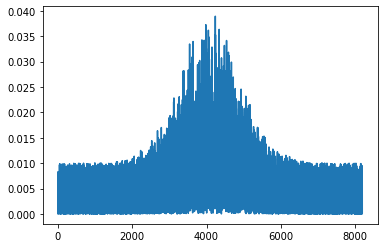

In [148]:
# initial condition
uu = np.array(0.1*np.random.rand(Nt)*initial_conditions() + 0.1*np.random.rand(Nt), dtype=np.complex128)
#uu = np.array(0.1*initial_conditions(), dtype=np.complex128)

plt.plot(np.abs(uu)**2)

In [165]:
plan = cudafft.Plan(uu.shape, np.complex128, np.complex128, batch=1)
omega = 2*np.pi*np.fft.fftfreq(uu.size,Dtau)
omega_d = gpuarray.to_gpu(omega)
array_d = pycuda.cumath.exp(0.5j*Beta2*omega_d**2*Deltaz/2.0 + 1j*omega_d**3*Beta3/6*Deltaz/2.0-Alpha*Deltaz/2.0)
vv_d = gpuarray.empty((1, len(uu)), np.complex128)
vv_d[0] = gpuarray.to_gpu(uu)
W_prev = np.zeros(1)
E_prev = np.zeros(1)
E = np.empty(1, dtype=np.float64)
E[0] = np.sum(np.abs(uu)**2)
width = np.empty(1, dtype=np.float64)
width[0] = p_width(np.abs(uu**2),Dtau*T_0)
i = 0
while ((np.abs(E[0]-E_prev[0])/E[0] > 0.0001 or np.abs(width[0] - W_prev[0])/width[0] > 0.001)):
    full_loop(vv_d,i, plan, array_d, absorber, fft_step, calc_energy, calc_g, non_linear_step)
    W_prev[0] = width[0]
    E_prev[0] = E[0]
    E[0] = np.sum(np.abs(vv_d[0].get())**2)
    width[0] = p_width(np.abs(vv_d[0].get())**2,Dtau*T_0)
    print('Energy is', E) 
    print('Frame is', i)
    i=i+1

Energy is [44.85386806]
Frame is 0
Energy is [44.86959409]
Frame is 1
Energy is [44.88781526]
Frame is 2
Energy is [44.90941932]
Frame is 3
Energy is [44.93019046]
Frame is 4
Energy is [44.94857149]
Frame is 5
Energy is [44.97461004]
Frame is 6
Energy is [44.99763393]
Frame is 7
Energy is [45.0289249]
Frame is 8
Energy is [45.05921424]
Frame is 9
Energy is [45.09251034]
Frame is 10
Energy is [45.12792349]
Frame is 11
Energy is [45.16517604]
Frame is 12
Energy is [45.19969292]
Frame is 13
Energy is [45.23724655]
Frame is 14
Energy is [45.27818557]
Frame is 15
Energy is [45.32145848]
Frame is 16
Energy is [45.36833791]
Frame is 17
Energy is [45.41425578]
Frame is 18
Energy is [45.46526702]
Frame is 19
Energy is [45.52046434]
Frame is 20
Energy is [45.57533034]
Frame is 21
Energy is [45.63773487]
Frame is 22
Energy is [45.6982682]
Frame is 23
Energy is [45.75858633]
Frame is 24
Energy is [45.82091415]
Frame is 25
Energy is [45.88372721]
Frame is 26
Energy is [45.94881244]
Frame is 27
Ener

Energy is [266.49858705]
Frame is 223
Energy is [266.3198967]
Frame is 224
Energy is [266.13550057]
Frame is 225
Energy is [265.94445255]
Frame is 226
Energy is [265.74679184]
Frame is 227
Energy is [265.54203794]
Frame is 228
Energy is [265.32976416]
Frame is 229
Energy is [265.10982486]
Frame is 230
Energy is [264.88220021]
Frame is 231
Energy is [264.64717002]
Frame is 232
Energy is [264.40519553]
Frame is 233
Energy is [264.15666879]
Frame is 234
Energy is [263.90213898]
Frame is 235
Energy is [263.641442]
Frame is 236
Energy is [263.37530561]
Frame is 237
Energy is [263.10504704]
Frame is 238
Energy is [262.83018788]
Frame is 239
Energy is [262.55040845]
Frame is 240
Energy is [262.26716736]
Frame is 241
Energy is [261.98160523]
Frame is 242
Energy is [261.69145297]
Frame is 243
Energy is [261.39468661]
Frame is 244
Energy is [261.09402244]
Frame is 245
Energy is [260.79196241]
Frame is 246
Energy is [260.48640372]
Frame is 247
Energy is [260.17505258]
Frame is 248
Energy is [259.

Energy is [265.45216148]
Frame is 440
Energy is [266.40633627]
Frame is 441
Energy is [267.34141214]
Frame is 442
Energy is [268.25871807]
Frame is 443
Energy is [269.26755362]
Frame is 444
Energy is [270.27970921]
Frame is 445
Energy is [271.34892704]
Frame is 446
Energy is [272.53427396]
Frame is 447
Energy is [273.60894874]
Frame is 448
Energy is [274.69585814]
Frame is 449
Energy is [275.82348844]
Frame is 450
Energy is [276.81733576]
Frame is 451
Energy is [277.77684789]
Frame is 452
Energy is [278.73195794]
Frame is 453
Energy is [279.62571573]
Frame is 454
Energy is [280.48485515]
Frame is 455
Energy is [281.3136542]
Frame is 456
Energy is [282.11004005]
Frame is 457
Energy is [282.89599998]
Frame is 458
Energy is [283.66829688]
Frame is 459
Energy is [284.39613801]
Frame is 460
Energy is [285.13283657]
Frame is 461
Energy is [285.88081283]
Frame is 462
Energy is [286.600255]
Frame is 463
Energy is [287.29683107]
Frame is 464
Energy is [287.97706596]
Frame is 465
Energy is [288.

### Visualization

In [166]:
import cv2
import os                                             

image_folder = 'Iterations'
video_name = 'result.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
print("finished")

finished


In [167]:
from moviepy.editor import *
clip = VideoFileClip('./result.avi')
clip.ipython_display(width = 460, maxduration=100)

t:   5%|▍         | 27/556 [00:00<00:02, 263.93it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
